In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.layers import Conv1D, TimeDistributed, Flatten, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
from numpy import genfromtxt

In [3]:
def get_data():
    input_file = '/Users/niall/Documents/Cypress_Code/Data/Multipath/channel_two_data.csv'
    my_data_flipped = genfromtxt(input_file, delimiter=',')

    new_data = np.delete(my_data_flipped, (0), axis=0)
    X2 = np.delete(new_data, (0,39), axis=1)
    Y2 = new_data[:,39]
    X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.25, random_state=42, shuffle=True)
    X_train = np.array(X_train).reshape((np.shape(X_train)[0], 1, np.shape(X_train)[1]))
    X_test = np.array(X_test).reshape((np.shape(X_test)[0], 1, np.shape(X_test)[1]))

    return X_train, X_test, y_train, y_test

In [4]:
flip_bit_data = get_data()

In [5]:
X_train = flip_bit_data[0]
X_test = flip_bit_data[1]
y_train = flip_bit_data[2]
y_test = flip_bit_data[3]

In [6]:
num_neurons = 38
num_features = 38


model = Sequential()
model.add(LSTM(num_neurons, input_shape=(1, num_features), return_sequences=True))
model.add(LSTM(num_neurons, input_shape=(1, num_features), return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model.summary()

print("inputs: " , model.input_shape)
print("outputs: ", model.output_shape)
print("actual inputs: ", np.shape(X_train))
print("actual outputs: ", np.shape(y_train))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 38)             11704     
_________________________________________________________________
lstm_1 (LSTM)                (None, 38)                11704     
_________________________________________________________________
dense (Dense)                (None, 1)                 39        
Total params: 23,447
Trainable params: 23,447
Non-trainable params: 0
_________________________________________________________________
inputs:  (None, 1, 38)
outputs:  (None, 1)
actual inputs:  (390000, 1, 38)
actual outputs:  (390000,)


In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
print('Training LSTM...')

batch_size = 5

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=5,
          validation_data=(X_test, y_test))

Training LSTM...
Train on 390000 samples, validate on 130000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
390000/390000 [==============================] - 485s 1ms/sample - loss: 0.0192 - acc: 0.9937 - val_loss: 0.0150 - val_acc: 0.9948
Epoch 2/5
390000/390000 [==============================] - 448s 1ms/sample - loss: 0.0125 - acc: 0.9958 - val_loss: 0.0144 - val_acc: 0.9950
Epoch 3/5
390000/390000 [==============================] - 442s 1ms/sample - loss: 0.0109 - acc: 0.9962 - val_loss: 0.0141 - val_acc: 0.9952
Epoch 4/5
390000/390000 [==============================] - 444s 1ms/sample - loss: 0.0097 - acc: 0.9967 - val_loss: 0.0142 - val_acc: 0.9953
Epoch 5/5
390000/390000 [==============================] - 440s 1ms/sample - loss: 0.0088 - acc: 0.9971 - val_loss: 0.0150 - val_acc: 0.9952


130000/130000 [==============================] - 6s 46us/sample - loss: 0.0150 - acc: 0.99520s - loss: 0.0151 - acc: 0.995
Test Loss:  0.015040908896885453
Test Accuracy 0.99520767
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


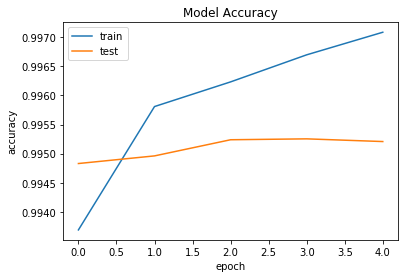

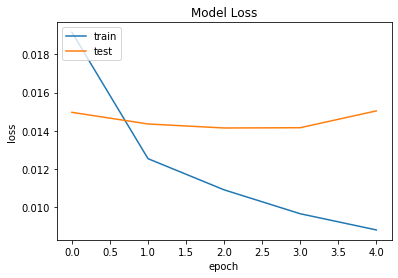

In [11]:
score = model.evaluate(X_test, y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
# Let's save the model to disc
json = model.to_json()
with open("/Users/niall/Documents/Cypress_Code/Models/LSTM/Multipath/model_one_channel_two.json", "w") as file:
    file.write(json)
model.save_weights("/Users/niall/Documents/Cypress_Code/Models/LSTM/Multipath/model_one_channel_two.h5")
print("Saved model to disc")

Saved model to disc


In [13]:
# Load the model of interest
json_file = open('/Users/niall/Documents/Cypress_Code/Models/LSTM/Multipath/model_one_channel_two.json', 'r')
json = json_file.read()
json_file.close()
model_avg_from_disc = model_from_json(json)
model_avg_from_disc.load_weights("/Users/niall/Documents/Cypress_Code/Models/LSTM/Multipath/model_one_channel_two.h5")

In [14]:
y_preds_lstm_minus = model_avg_from_disc.predict(X_test, batch_size=1)

In [15]:
pred_avg = pd.DataFrame(y_preds_lstm_minus, columns =['Y_pred']) 
pred_avg['Label'] = y_test

In [16]:
pred_avg.to_csv('/Users/niall/Documents/Cypress_Code/Predictions/LSTM/Multipath/model_one_channel_two.csv', index = False)

In [17]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))

In [18]:
preds_new = model_avg_from_disc.predict_classes(X_test)
metrics(preds_new, y_test)

F1-score:  0.995018908957169
Precision:  0.9950746006108775
Recall:  0.9949632235369363
Acuracy:  0.9952076923076923
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67460
           1       1.00      0.99      1.00     62540

    accuracy                           1.00    130000
   macro avg       1.00      1.00      1.00    130000
weighted avg       1.00      1.00      1.00    130000

